<a href="https://colab.research.google.com/github/Mudachir/IMAGE-BASED-DETECTION-AND-CLASSIFICATION-OF-PULMONARY-ABNORMALITIES-USING-DEEP-LEARNING-TECHNIQUES/blob/main/ResNet_152%2C_EfficientNetB7_and_Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Loading, Pre-Processing and Data Augmentation#

###Loading Dataset from Google Drive###

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dataset_dir = '/content/drive/MyDrive/Dataset'

Mounted at /content/drive


In [ ]:
# Define the paths to the folders
covid_path = '/content/drive/MyDrive/Dataset/COVID'
normal_path = '/content/drive/MyDrive/Dataset/Normal'
lung_opacity_path = '/content/drive/MyDrive/Dataset/Lung_Opacity'
viral_pneumonia_path = '/content/drive/MyDrive/Dataset/Viral Pneumonia'

In [ ]:
# Load the images and labels for each class
import os
import cv2
import numpy as np
def loadImages(path, urls, target):
    images = []
    labels = []
    for i in range(len(urls)):
        img_path = path + "/" + urls[i]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        if img is None:
            continue
        img = img / 255.0  # Normalize the image
        img = cv2.resize(img, (224, 224))  # Resize to match VGG16 input
        images.append(img)
        labels.append(target)
    images = np.asarray(images)
    return images, labels


In [ ]:
# Load images from all categories
covidUrls = os.listdir(covid_path)
covidImages, covidTargets = loadImages(covid_path, covidUrls, 0)  # 0 for COVID

normalUrls = os.listdir(normal_path)
normalImages, normalTargets = loadImages(normal_path, normalUrls, 1)  # 1 for Normal

lungOpacityUrls = os.listdir(lung_opacity_path)
lungOpacityImages, lungOpacityTargets = loadImages(lung_opacity_path, lungOpacityUrls, 2)  # 2 for Lung Opacity

viralPneumoniaUrls = os.listdir(viral_pneumonia_path)
viralPneumoniaImages, viralPneumoniaTargets = loadImages(viral_pneumonia_path, viralPneumoniaUrls, 3)  # 3 for Viral Pneumonia

###Spliting Dataset to Train and Test###

In [ ]:
from sklearn.model_selection import train_test_split
# Combine the images and labels
data = np.r_[covidImages, normalImages, lungOpacityImages, viralPneumoniaImages]
targets = np.r_[covidTargets, normalTargets, lungOpacityTargets, viralPneumoniaTargets]
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data, targets, test_size=0.25, random_state=42)

###Data Augmentation For Resnet-152 and EfficentNet b7##

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define the data augmentation transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0,
                            translate=(0.1, 0.1)),  # Width and height shifts of 10%
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [ ]:


from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np


# Images are kept as NumPy arrays for transformation
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


# Create a custom dataset
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:

            image = transforms.ToPILImage()(image)
            image = self.transform(image)
        return image, label






###Apply data transformations using the CustomDataset###

In [ ]:
# Apply data transformations using the CustomDataset
train_dataset = CustomDataset(x_train, y_train_tensor, transform=data_transforms)
test_dataset = CustomDataset(x_test, y_test_tensor, transform=data_transforms)


###Create SubsetRandomSamplers, data loaders and passing the datasets and samplers###

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split

# Create SubsetRandomSamplers for your datasets
train_sampler = SubsetRandomSampler(range(len(train_dataset)))
test_sampler = SubsetRandomSampler(range(len(test_dataset)))

# Create data loaders, passing the datasets and samplers
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
test_loader = DataLoader(test_dataset, batch_size=32, sampler=test_sampler)

###Visualize the augmented dataset###

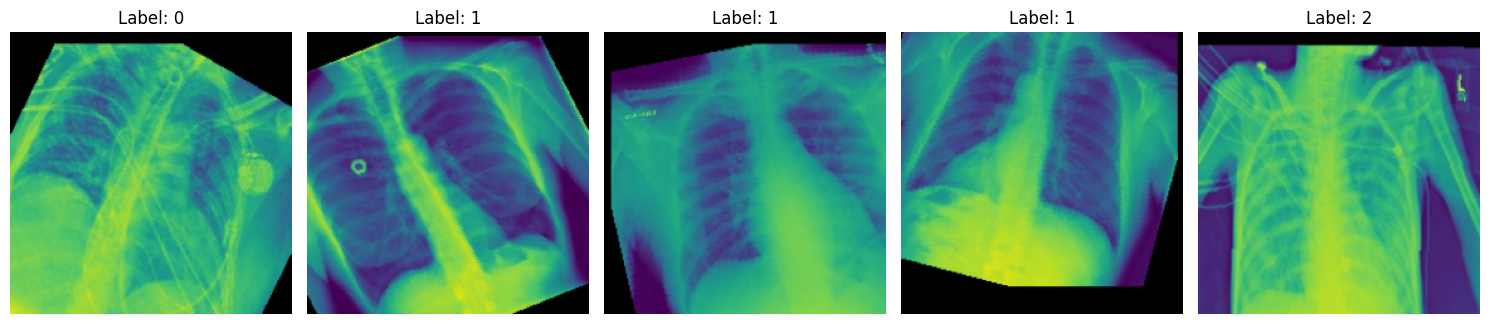

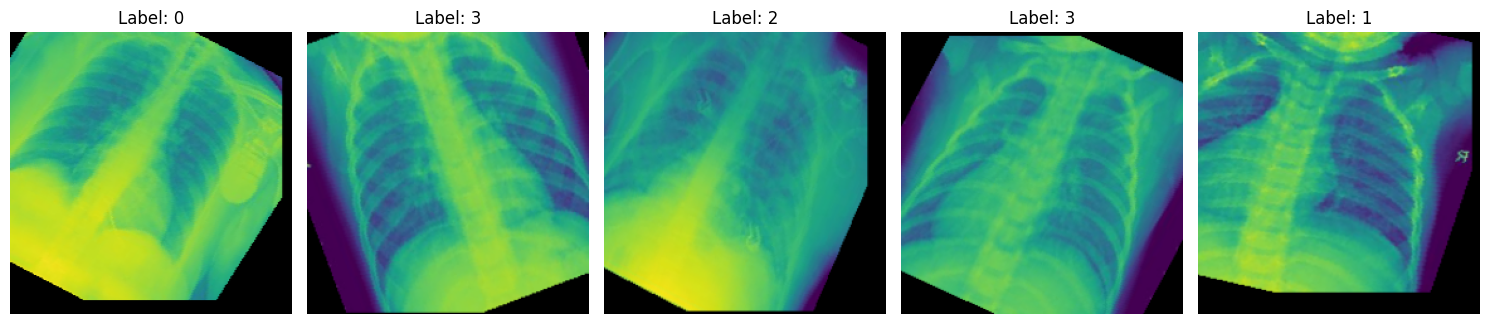

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to visualize images with labels
def visualize_augmented_images(dataloader, num_images=5):

    images, labels = next(iter(dataloader))

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))


    for i in range(num_images):

        image_np = images[i].permute(1, 2, 0).numpy()
        # Unnormalize the image
        image_np = (image_np * 0.5) + 0.5

        axes[i].imshow(image_np)
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()



visualize_augmented_images(train_loader)

visualize_augmented_images(test_loader)

#Model Implementation and Validation#

In [ ]:
batch_size = 32
num_epochs = 50
initial_learning_rate = 1e-4
num_classes = 4

# Define focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

##ResNet - 152 ##

###Initialize the ResNet model###

In [ ]:
model_name = 'resnet152'
model = models.__dict__[model_name](pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)
criterion = FocalLoss()

###Training Loop###

Epoch 1/50, Train Loss: 0.7436, Train Acc: 31.04%, Test Loss: 0.6705, Test Acc: 43.51%
Epoch 2/50, Train Loss: 0.6032, Train Acc: 54.24%, Test Loss: 0.5365, Test Acc: 61.04%
Epoch 3/50, Train Loss: 0.4788, Train Acc: 66.18%, Test Loss: 0.4310, Test Acc: 66.92%
Epoch 4/50, Train Loss: 0.3817, Train Acc: 69.56%, Test Loss: 0.3439, Test Acc: 69.76%
Epoch 5/50, Train Loss: 0.3091, Train Acc: 71.68%, Test Loss: 0.2781, Test Acc: 72.70%
Epoch 6/50, Train Loss: 0.2592, Train Acc: 74.30%, Test Loss: 0.2386, Test Acc: 73.74%
Epoch 7/50, Train Loss: 0.2177, Train Acc: 74.68%, Test Loss: 0.2087, Test Acc: 73.36%
Epoch 8/50, Train Loss: 0.1888, Train Acc: 76.17%, Test Loss: 0.1693, Test Acc: 76.30%
Epoch 9/50, Train Loss: 0.1705, Train Acc: 77.05%, Test Loss: 0.1561, Test Acc: 75.73%
Epoch 10/50, Train Loss: 0.1511, Train Acc: 78.00%, Test Loss: 0.1355, Test Acc: 78.48%
Epoch 11/50, Train Loss: 0.1348, Train Acc: 78.54%, Test Loss: 0.1241, Test Acc: 78.96%
Epoch 12/50, Train Loss: 0.1194, Train Ac

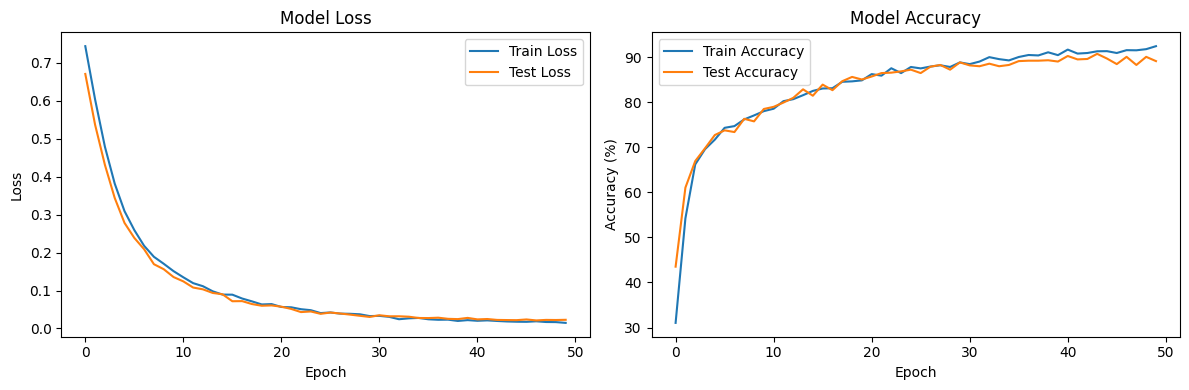

In [ ]:
# Training loop
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

# Plot the model accuracy and loss graphs
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

###Train loop without Graph###

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")



Epoch 1/50, Loss: 0.7412229607803653
Epoch 2/50, Loss: 0.5930927067694037
Epoch 3/50, Loss: 0.4764244932718951
Epoch 4/50, Loss: 0.37365677772146283
Epoch 5/50, Loss: 0.30337947080231675
Epoch 6/50, Loss: 0.2505717720046188
Epoch 7/50, Loss: 0.20923539032839766
Epoch 8/50, Loss: 0.1781227725623834
Epoch 9/50, Loss: 0.16164058537194223
Epoch 10/50, Loss: 0.14276492418815392
Epoch 11/50, Loss: 0.12448521120229153
Epoch 12/50, Loss: 0.10816521351837148
Epoch 13/50, Loss: 0.10398290174627545
Epoch 14/50, Loss: 0.09171368700988365
Epoch 15/50, Loss: 0.08079295701375513
Epoch 16/50, Loss: 0.07607722918343063
Epoch 17/50, Loss: 0.07312167148021134
Epoch 18/50, Loss: 0.06894026954441962
Epoch 19/50, Loss: 0.05808509351930233
Epoch 20/50, Loss: 0.05589888378450967
Epoch 21/50, Loss: 0.05409117165313224
Epoch 22/50, Loss: 0.05060560831028705
Epoch 23/50, Loss: 0.04476049089935994
Epoch 24/50, Loss: 0.04577197072876975
Epoch 25/50, Loss: 0.039601425764931725
Epoch 26/50, Loss: 0.04091093542449402

In [ ]:
# prompt: generate a model accuracy and model loss graph of above model

import matplotlib.pyplot as plt

# Assuming you have lists or arrays named 'train_losses' and 'train_accuracies'
# that store the loss and accuracy values from each epoch during training.

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss') # Replace with your training loss data
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


# Plot the training accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy') # Replace with your training accuracy data
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

###Testing Loop###

In [ ]:
# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 91.09%


###Save the Trained Model : Resnet-152###

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/Resnet-152_FocalLoss.pth'  # Specify the path to save the model
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/Resnet-152_FocalLoss.pth


##Classification Report and Confusion Matrix of Resnet-152##

Confusion Matrix:


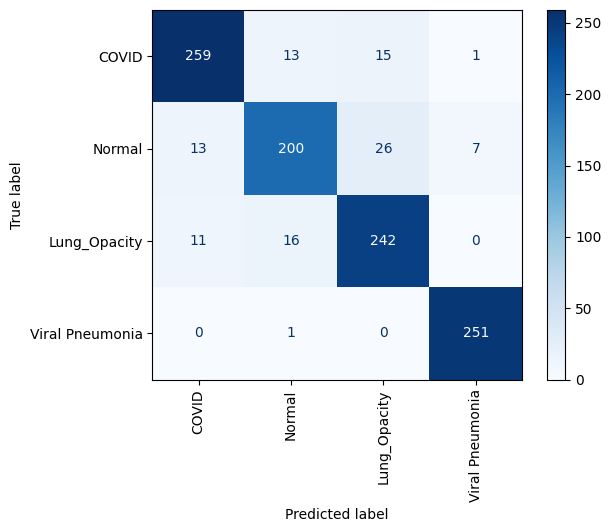

Classification Report of Resnet-152:
                 precision    recall  f1-score   support

          COVID       0.92      0.90      0.91       288
         Normal       0.87      0.81      0.84       246
   Lung_Opacity       0.86      0.90      0.88       269
Viral Pneumonia       0.97      1.00      0.98       252

       accuracy                           0.90      1055
      macro avg       0.90      0.90      0.90      1055
   weighted avg       0.90      0.90      0.90      1055



In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Assuming you have a list of class names (replace with your actual class names)
class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Function to calculate metrics including support for each class
def evaluate_model(model, test_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.show()

    # Calculate and display classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report of Resnet-152:")
    print(report)

    # Save the classification report to a text file
    with open('/content/drive/MyDrive/Classification Report 3 of Resnet-152.txt', 'w') as f:
        f.write("Classification Report:\n")
        f.write(report)
# Example: Evaluate the model
evaluate_model(model, test_loader, device, class_names)


##Resnet - 18##

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define hyperparameters
batch_size = 32
num_epochs = 50
initial_learning_rate = 1e-6
num_classes = 4  # Adjust for the number of target classes (COVID-19, Pneumonia, etc.)

# Define focal loss
class FocalLoss_res18(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss_res18, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss()(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss

###Loading Resnet-18 Pre-Trained Model###

In [ ]:

# Load the pre-trained ResNet-18 model
resnet18_model = models.resnet18(pretrained=True)
# Modify the fully connected layer for your number of classes
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model = resnet18_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


###loss function and optimizer###

In [ ]:
# Define the loss function and optimizer
criterion = FocalLoss_res18() # Assuming FocalLoss is defined as in your original code
optimizer = optim.Adam(resnet18_model.parameters(), lr=initial_learning_rate)

###Training Loop###

In [ ]:
# Training loop (using your existing train_loader)
for epoch in range(num_epochs):
    resnet18_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet18_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/50, Loss: 0.8498381195646344
Epoch 2/50, Loss: 0.7133214359331612
Epoch 3/50, Loss: 0.6016711279599354
Epoch 4/50, Loss: 0.5192995881191408
Epoch 5/50, Loss: 0.4383232157037716
Epoch 6/50, Loss: 0.3794543458656831
Epoch 7/50, Loss: 0.33671305757580383
Epoch 8/50, Loss: 0.3053598291043079
Epoch 9/50, Loss: 0.2738464382862804
Epoch 10/50, Loss: 0.25306689408090377
Epoch 11/50, Loss: 0.2254524137636628
Epoch 12/50, Loss: 0.20601505146484184
Epoch 13/50, Loss: 0.20435278426216105
Epoch 14/50, Loss: 0.18243104497892687
Epoch 15/50, Loss: 0.17371322876877254
Epoch 16/50, Loss: 0.16522042746796753
Epoch 17/50, Loss: 0.1535874516750225
Epoch 18/50, Loss: 0.143501241926593
Epoch 19/50, Loss: 0.13473369049453976
Epoch 20/50, Loss: 0.12766859729332153
Epoch 21/50, Loss: 0.12774351528949207
Epoch 22/50, Loss: 0.11707900671495332
Epoch 23/50, Loss: 0.11152024634859779
Epoch 24/50, Loss: 0.11175428782448624
Epoch 25/50, Loss: 0.10458936561087165
Epoch 26/50, Loss: 0.10270920723225131
Epoch 2

###Save the Trained Model Resnet-18###

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Resnet18_focalloss.pth')
print("Model saved successfully!")

Model saved successfully!


###Test Loop###

In [ ]:
resnet18_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.52%


##Classification Report for Resnet-18##

Confusion Matrix:


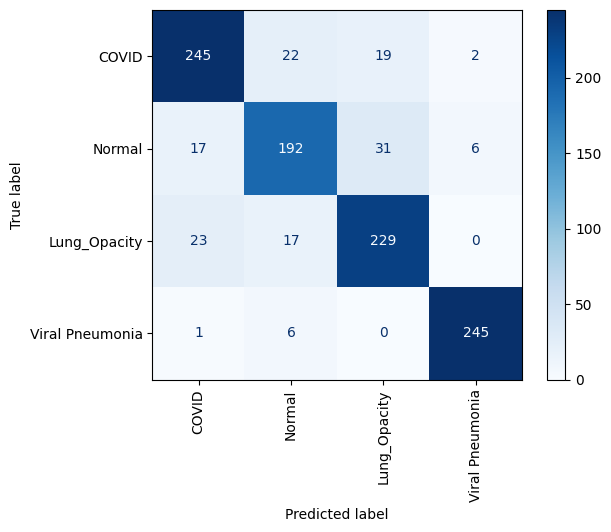

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.86      0.85      0.85       288
         Normal       0.81      0.78      0.80       246
   Lung_Opacity       0.82      0.85      0.84       269
Viral Pneumonia       0.97      0.97      0.97       252

       accuracy                           0.86      1055
      macro avg       0.86      0.86      0.86      1055
   weighted avg       0.86      0.86      0.86      1055



In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Assuming you have a list of class names (replace with your actual class names)
class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

# Function to calculate metrics including support for each class
def evaluate_model(model, test_loader, device, class_names):
    """
    Evaluates the model on the test dataset and calculates confusion matrix,
    precision, recall, F1-score, support, both macro and weighted averages.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test set.
        device: Device (CPU or GPU) for computation.
        class_names: List of class names for labeling the confusion matrix.

    Returns:
        None (prints metrics and displays confusion matrix).
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.show()

    # Calculate and display classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

    # Save the classification report to a text file
    with open('/content/drive/MyDrive/classification_report_resnet18.txt', 'w') as f:
        f.write("Classification Report Resnet18:\n")
        f.write(report)



# Example: Evaluate the model
evaluate_model(resnet18_model, test_loader, device, class_names)


##EfficientNet b7##

In [ ]:
import torch
import torch.nn as nn
from torchvision import models


class EfficientNetB7Model(nn.Module):
    def __init__(self, num_classes=None):
        super(EfficientNetB7Model, self).__init__()

        # Load pre-trained EfficientNet-B7
        self.efficientnet_b7 = models.efficientnet_b7(pretrained=True)

        # Remove the classifier layer and replace it with Global Average Pooling (GAP)
        self.efficientnet_b7.classifier = nn.Sequential(
            nn.Linear(self.efficientnet_b7.classifier[1].in_features, 1000),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1000, num_classes)
        )

        # Optional sigmoid activation for binary classification
        self.sigmoid = nn.Sigmoid() if num_classes == 1 else nn.Identity()

    def forward(self, x):
        # Forward pass through EfficientNet-B7
        x = self.efficientnet_b7(x)
        return self.sigmoid(x)

num_classes = 4
efficientnet_model = EfficientNetB7Model(num_classes=num_classes)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 225MB/s]


Epoch [1/20], Train Loss: 0.6962, Train Acc: 74.37%, Test Loss: 2.8981, Test Acc: 69.19%
Epoch [2/20], Train Loss: 0.4871, Train Acc: 81.92%, Test Loss: 0.5895, Test Acc: 81.42%
Epoch [3/20], Train Loss: 0.4182, Train Acc: 85.05%, Test Loss: 0.8824, Test Acc: 76.30%
Epoch [4/20], Train Loss: 0.3117, Train Acc: 89.44%, Test Loss: 0.4173, Test Acc: 87.77%
Epoch [5/20], Train Loss: 0.2820, Train Acc: 90.08%, Test Loss: 0.5200, Test Acc: 85.78%
Epoch [6/20], Train Loss: 0.2809, Train Acc: 90.74%, Test Loss: 0.4698, Test Acc: 87.58%
Epoch [7/20], Train Loss: 0.2620, Train Acc: 90.58%, Test Loss: 0.6234, Test Acc: 84.83%
Epoch [8/20], Train Loss: 0.2266, Train Acc: 91.78%, Test Loss: 0.4194, Test Acc: 89.00%
Epoch [9/20], Train Loss: 0.1885, Train Acc: 93.87%, Test Loss: 0.4206, Test Acc: 85.78%
Epoch [10/20], Train Loss: 0.2242, Train Acc: 92.04%, Test Loss: 0.2510, Test Acc: 90.71%
Epoch [11/20], Train Loss: 0.1936, Train Acc: 93.11%, Test Loss: 0.3543, Test Acc: 87.01%
Epoch [12/20], Trai

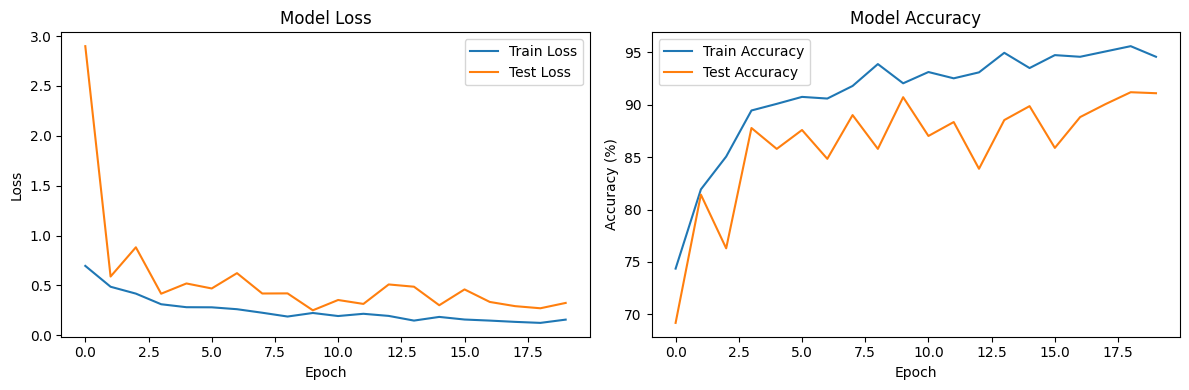

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model = efficientnet_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=0.001)
# Training loop
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    efficientnet_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing phase
    efficientnet_model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = efficientnet_model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")


# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

In [ ]:

import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model = efficientnet_model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(efficientnet_model.parameters(), lr=1e-4)

num_epochs = 50

for epoch in range(num_epochs):
    efficientnet_model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if (i+1) % 10 == 0 :    # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

# Save the trained model
torch.save(efficientnet_model.state_dict(), '/content/drive/MyDrive/efficientnet_b7_model_BCE.pth')
print("Model saved successfully!")

[1,    10] loss: 1.354
[1,    20] loss: 1.205
[1,    30] loss: 0.959
[1,    40] loss: 0.772
[1,    50] loss: 0.697
[1,    60] loss: 0.575
[1,    70] loss: 0.425
[1,    80] loss: 0.484
[1,    90] loss: 0.377
[2,    10] loss: 0.304
[2,    20] loss: 0.265
[2,    30] loss: 0.353
[2,    40] loss: 0.282
[2,    50] loss: 0.392
[2,    60] loss: 0.438
[2,    70] loss: 0.326
[2,    80] loss: 0.392
[2,    90] loss: 0.310
[3,    10] loss: 0.244
[3,    20] loss: 0.265
[3,    30] loss: 0.215
[3,    40] loss: 0.243
[3,    50] loss: 0.325
[3,    60] loss: 0.202
[3,    70] loss: 0.236
[3,    80] loss: 0.193
[3,    90] loss: 0.225
[4,    10] loss: 0.262
[4,    20] loss: 0.178
[4,    30] loss: 0.260
[4,    40] loss: 0.168
[4,    50] loss: 0.179
[4,    60] loss: 0.197
[4,    70] loss: 0.282
[4,    80] loss: 0.204
[4,    90] loss: 0.192
[5,    10] loss: 0.119
[5,    20] loss: 0.129
[5,    30] loss: 0.100
[5,    40] loss: 0.224
[5,    50] loss: 0.175
[5,    60] loss: 0.234
[5,    70] loss: 0.149
[5,    80] 

###Test Loop###

In [ ]:
efficientnet_model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 90.81%


##Classification report and Confusion Matrix of EfficientNet b7##

Confusion Matrix:


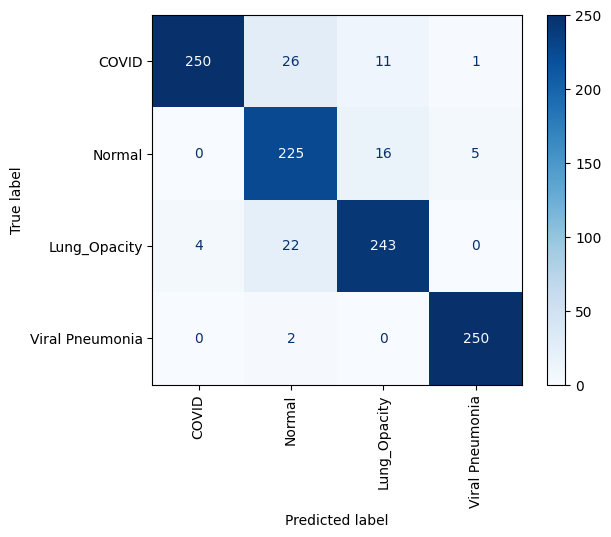

Classification Report:
                 precision    recall  f1-score   support

          COVID       0.98      0.87      0.92       288
         Normal       0.82      0.91      0.86       246
   Lung_Opacity       0.90      0.90      0.90       269
Viral Pneumonia       0.98      0.99      0.98       252

       accuracy                           0.92      1055
      macro avg       0.92      0.92      0.92      1055
   weighted avg       0.92      0.92      0.92      1055



In [ ]:
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']


def evaluate_model(model, test_loader, device, class_names):

    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Display confusion matrix
    print("Confusion Matrix:")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.show()

    # Calculate and display classification report
    report = classification_report(all_labels, all_preds, target_names=class_names)
    print("Classification Report:")
    print(report)

    # Save the classification report to a text file
    #with open('/content/drive/MyDrive/classification_report_efficientnetb7.txt', 'w') as f:
        #f.write("Classification Report EfficientNet b7:\n")
        #f.write(report)




evaluate_model(efficientnet_model, test_loader, device, class_names)


##Weighted Avg Ensemble##

###Calculate Weights###



Model 1 = Efficientnet b7 = 0.92<br><br>
Model 2 = Resnet 18 = 0.86<br><br>
Model 3 = Resnet 152 = 0.90<br><br>

For Weighted Avg Ensemble we will calculate Weights best two models.

In [ ]:
model_n = [0.92,0.90]

w= []#To store calculated weights
for model_nth in model_n:
  w.append((model_nth) / (model_n[0] + model_n[1]))
print(w)



[0.5054945054945055, 0.4945054945054945]


###Weighted ensemble two best saved models###

In [ ]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Load the saved models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


num_classes = 4
efficientnet_model = EfficientNetB7Model(num_classes=num_classes).to(device)

model_name = 'resnet152'
resnet152_model = models.__dict__[model_name](pretrained=False)
resnet152_model.fc = nn.Linear(resnet152_model.fc.in_features, num_classes)
resnet152_model = resnet152_model.to(device)


# Load state dicts
efficientnet_model.load_state_dict(torch.load('/content/drive/MyDrive/efficientnet_b7_model_BCE.pth', map_location=device))
resnet152_model.load_state_dict(torch.load('/content/drive/MyDrive/Resnet-152_FocalLoss.pth', map_location=device))


efficientnet_model.eval()
resnet152_model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-19-96a3048a079b>:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###Train Loop weighted ensemple for Con Matrix###


Epoch [1/50], Train Loss: 0.0269, Train Acc: 99.18%, Test Loss: 0.2678, Test Acc: 92.61%
Epoch [2/50], Train Loss: 0.0229, Train Acc: 99.40%, Test Loss: 0.2571, Test Acc: 92.70%
Epoch [3/50], Train Loss: 0.0205, Train Acc: 99.49%, Test Loss: 0.2482, Test Acc: 93.27%
Epoch [4/50], Train Loss: 0.0224, Train Acc: 99.37%, Test Loss: 0.2615, Test Acc: 93.08%
Epoch [5/50], Train Loss: 0.0180, Train Acc: 99.49%, Test Loss: 0.2696, Test Acc: 92.23%
Epoch [6/50], Train Loss: 0.0220, Train Acc: 99.18%, Test Loss: 0.2793, Test Acc: 92.42%
Epoch [7/50], Train Loss: 0.0208, Train Acc: 99.46%, Test Loss: 0.2369, Test Acc: 92.89%
Epoch [8/50], Train Loss: 0.0237, Train Acc: 99.24%, Test Loss: 0.2428, Test Acc: 93.46%
Epoch [9/50], Train Loss: 0.0197, Train Acc: 99.43%, Test Loss: 0.2703, Test Acc: 92.61%
Epoch [10/50], Train Loss: 0.0201, Train Acc: 99.30%, Test Loss: 0.2535, Test Acc: 92.89%
Epoch [11/50], Train Loss: 0.0201, Train Acc: 99.43%, Test Loss: 0.2611, Test Acc: 92.70%
Epoch [12/50], Trai

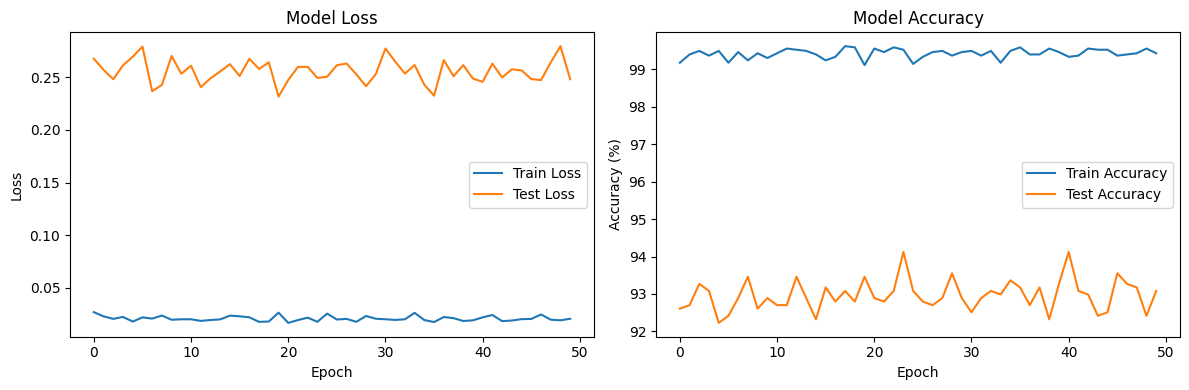

In [ ]:


# Training loop for weighted ensemble
num_epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):

    efficientnet_model.train()
    resnet152_model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass through both models
        outputs_efficientnet = efficientnet_model(inputs)
        outputs_resnet152 = resnet152_model(inputs)

        # Weighted average of predictions
        outputs = w[0] * outputs_efficientnet + w[1] * outputs_resnet152

        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)


    efficientnet_model.eval()
    resnet152_model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs_efficientnet = efficientnet_model(inputs)
            outputs_resnet152 = resnet152_model(inputs)
            outputs = w[0] * outputs_efficientnet + w[1] * outputs_resnet152
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_loss / len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)


    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

# Plot the accuracy and loss graphs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

##Validation, Classification report and Confusion Matrix##

Confusion Matrix:


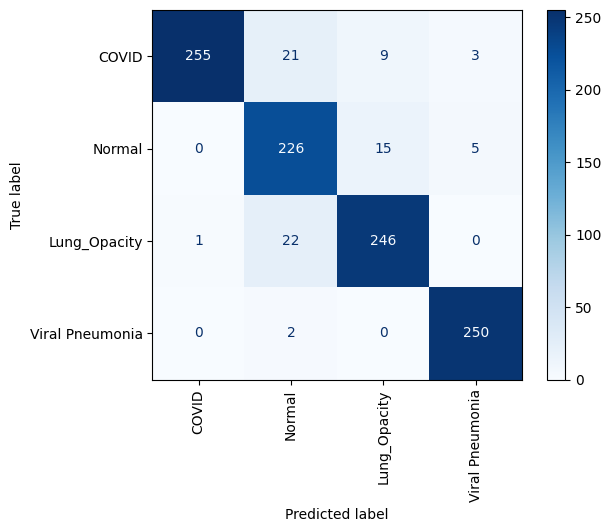

Classification Report:
                 precision    recall  f1-score   support

          COVID       1.00      0.89      0.94       288
         Normal       0.83      0.92      0.87       246
   Lung_Opacity       0.91      0.91      0.91       269
Viral Pneumonia       0.97      0.99      0.98       252

       accuracy                           0.93      1055
      macro avg       0.93      0.93      0.93      1055
   weighted avg       0.93      0.93      0.93      1055



In [ ]:

w= [0.51,0.50]#evaluated

class_names = ['COVID', 'Normal', 'Lung_Opacity', 'Viral Pneumonia']

def weighted_ensemble(input_tensor):
    with torch.no_grad():
        out1 = efficientnet_model(input_tensor)
        out2 = resnet152_model(input_tensor)

    ensemble_output = (w[0] * out1 + w[1] * out2)
    return ensemble_output


def evaluate_ensemble(model, test_loader, device, class_names):
  all_preds = []
  all_labels = []
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = weighted_ensemble(inputs)  # Use the ensemble model here
          _, preds = torch.max(outputs, 1)
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  cm = confusion_matrix(all_labels, all_preds)
  print("Confusion Matrix:")
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
  disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
  plt.show()

  report = classification_report(all_labels, all_preds, target_names=class_names)
  print("Classification Report:")
  print(report)
  return report

report = evaluate_ensemble(weighted_ensemble, test_loader, device, class_names)
with open('/content/drive/MyDrive/classification_report_ensemble.txt', 'w') as f:
    f.write(report)